### 크롤링 내용
- 상품명
- 가격
- 링크

In [1]:
# test = '이름 {name}, 나이 {age}'.format(name='홍길동', age=20)
# print(test)

이름 홍길동, 나이 20


# 쿠팡 특징
- 조회시 listSize=36 일 경우 27페이지 까지 보여진다. (어떤 상품을 조회해도 페이지는 계속 27페이지이다.)
    - listSize=72 로 하면 13페이지 
- 그래서 listSize를 크게하면 ex)100 하면 10 페이정도 나온다.
- GET 방식 요청이다.
- User Agent 설정해야 한다.
     - 안넣으면 OSError("(10060, 'WSAETIMEDOUT')" 에러. (해결: https://stackoverflow.com/questions/46862719/pythons-requests-library-timing-out-but-getting-the-response-from-the-browser)

# 1페이지 조회

- selector
    - base: ul#productList li
    - 제품명 : div.name : text
    - 상세링크: a :href속성
    - 판매가: strong.price-value : text

In [6]:
import requests
from bs4 import BeautifulSoup
from urllib import parse

#검색키워드 : keyworkd, 페이지 번호: pagenum
base_url = 'https://www.coupang.com/np/search?q={keyword}&page={pagenum}' 

link_list = []
item_name_list = []
price_list = []

keyword = input('검색키워드를 입력하시오: ')
url = base_url.format(keyword=keyword, pagenum=1)

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36'}
res = requests.get(url, headers=headers)
# print(res.status_code)
if res.status_code==200:
    soup = BeautifulSoup(res.text, 'html.parser')
#   item box li
    item_li_list = soup.select('ul#productList > li.search-product')
    error_cnt = 0 #크롤링 못한 item개수 저장
    for item in item_li_list:
        #중고의 경우 값이 제목에 붙은 경우가 있다. 이 때 NoneType이라고 Exception 발생. 이것은 대상에서 뺀다.
        try:
            item_name = item.select_one('div.name').text
            link = parse.urljoin(base_url, item.select_one('a').get('href'))
            price = item.select_one('strong.price-value').text
            price = ''.join(price.split(','))  # 단위구분자 , 제거
            link_list.append(link)
            item_name_list.append(item_name)
            price_list.append(price)
        except Exception as e:
            error_cnt += 1 #크롤링 못한 item개수 1 증가
            print(e)
            
        

검색키워드를 입력하시오: 노트북
200


In [5]:
len(link_list)

36

In [6]:
import pandas as pd
df = pd.DataFrame({'링크':link_list, '상품명':item_name_list, '가격':price_list})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   링크      36 non-null     object
 1   상품명     36 non-null     object
 2   가격      36 non-null     object
dtypes: object(3)
memory usage: 992.0+ bytes


In [7]:
df.head()

,링크,상품명,가격
0,/vp/products/1486166393?itemId=2552167861&vend...,삼성전자 노트북 PEN S NT950SBE-K58M (i5-8265U 38.1cm)...,1551170
1,/vp/products/1149803634?itemId=2123503405&vend...,LG전자 울트라 PC 노트북 14U390-EE1TK 화이트 (인텔 셀러론 N4100...,449000
2,/vp/products/1348981530?itemId=2376867898&vend...,아이뮤즈 노트북 STORMBOOK (N3350 35.8cm WIN10 Graphic...,264620
3,/vp/products/1676672325?itemId=2856499922&vend...,레노버 노트북 V14-ARE 82DQ003AKR (R5-4500U 35.56cm W...,459000
4,/vp/products/1825899405?itemId=3106699714&vend...,삼성 갤럭시 이온 NT950XCJ-X716A 아우라실버 (i7-10510U/16G/...,2231000


# 페이징을 통해 검색 item 읽기
- 검색하면 맨 아래 pagination에 마지막 페이지 번호가 나온다. 이것부터 크롤링
    - div.search-pagination > a.btn-last
- 그리고 페이지 단위로 크롤링 한다.    

In [23]:
import requests
from bs4 import BeautifulSoup
from urllib import parse
from datetime import datetime
import pandas as pd

# 결과 각각 넣기
item_name_list = []
link_list = []
price_list = []

# 다른 방식 조회결과 저장
result_list = []  #[(제품1),(제품2),(제품3), .. ] 식으로
keyword = input('검색어를 입력하세요:')
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36'
}
# 이것 보다 패턴문자 쓰는 것이 편함.
# params = {
#     'q':keyword,
#     'page':'1'
# }
###################################################################
# 페이지 번호 조회 - listSize=72
###################################################################
base_url = 'https://www.coupang.com/np/search?q={keyword}&page={pagenum}&listSize=72'
url = base_url.format(keyword=keyword, pagenum=1)
print(url)
res = requests.get(url, headers=headers)

last_page = None
if res.status_code == 200:
    soup = BeautifulSoup(res.text)
    last_page = soup.select_one('div.search-pagination > a.btn-last').text.strip()
    print('총 페이지수 : {}'.format(last_page))
    
###################################################################
# 페이지 번호 조회
###################################################################
error_cnt = 0 #크롤링 못한 item개수 저장
coupang_base_url = 'https://www.coupang.com/'
#페이지 반복
for page in range(1, int(last_page)+1):
    
    url = base_url.format(keyword=keyword, pagenum=page)
    res = requests.get(url, headers=headers)
    
    if res.status_code==200:
        soup = BeautifulSoup(res.text, 'lxml')
        #   item box li
        item_li_list = soup.select('ul#productList > li.search-product')
#         print(len(item_li_list))
        # 한페이지내의 item들 반복
        for item in item_li_list:

            #중고의 경우 값이 제목에 붙은 경우가 있다. 이 때 NoneType이라고 Exception 발생. 이것은 대상에서 뺀다.
            try:
                item_name = item.select_one('div.name').text.strip()
                link = parse.urljoin(coupang_base_url, item.select_one('a').get('href'))
                price = item.select_one('strong.price-value').text.strip()
                price = ''.join(price.split(','))  # 단위구분자 , 제거
                
                link_list.append(link)
                item_name_list.append(item_name)
                price_list.append(price)
                
                result_list.append([item_name, link, price])
            except Exception as e:
                error_cnt += 1 #크롤링 못한 item개수 1 증가
                print(page, idx,  item_name)

                
# 저장
curr = datetime.now().strftime('%Y-%m-%d')
filename = '쿠팡_{}_조회결과_{}.csv'.format(keyword, curr)
df = pd.DataFrame(result_list, columns=['상품명','상세페이지링크', '가격'])
df.to_csv(filename, index=False, encoding='UTF-8')
print('크롤링 못한 item개수 : %s' % error_cnt)            

검색어를 입력하세요:노트북
https://www.coupang.com/np/search?q=노트북&page=1&listSize=72
총 페이지수 : 13
6 72 미사용 리퍼 Razer Blade Stealth 노트북 13.3 FHD MX150, 단일상품, 단일상품
6 72 LG그램 14Z960 i5 4G 256G 14인치 중고노트북, win7
7 72 마이크로소프트 서피스 랩탑 i7 8G 256G 버건디 당일배송, SERJKQ-00036
7 72 DELL 프리시전 15 5520/i7-7820HQ/쿼드로 M1200M/FHD IPS/16GB/512GB PCIe SSD/정품윈도우/3년, 단일상품, 단일상품, 단일상품
7 72 DELL 래티튜드 5300/i5-8365U/인텔 그래픽/HD 디스플레이/8GB/128GB PCIe SSD/정품윈도우/3년무상AS, 단일상품, 단일상품, 단일상품
7 72 [예약판매] DELL 에일리언웨어 M15 R2 i7-9750H RTX2060 FHD 240Hz 16GB 512GBSSD WIN10Hom, 단일상품, 단일상품, 단일상품
7 72 [예약판매] DELL 인스피론 15 7590 i5-9300H GTX1650 FHD 8GB 1TB SSD WIN10Home 지문인식 1년, 단일상품, 단일상품, 단일상품
7 72 [예약판매] DELL 에일리언웨어 Area 51M i7-9700K RTX2080 FHD 144Hz 16GB 듀얼512GBSSD WIN1, 단일상품, 단일상품, 단일상품
7 72 DELL 래티튜드 5300 2in1/i5-8365U/인텔 그래픽/FHD 터치/16GB/512GB PCIe SSD/60WHR 배터리/정품, 단일상품, 단일상품, 단일상품
7 72 DELL 래티튜드 7390/i5-8250U/인텔 그래픽/FHD 터치/8GB/256GB PCIe SSD/정품윈도우/지문인식/3년무상AS, 단일상품, 단일상품, 단일상품
7 72 DELL 인스피론 15 7570 실버/i7-8550U/MX130/FHD IPS/8GB/512GB PCIe 

In [27]:
item_df = pd.read_csv('쿠팡_노트북_조회결과_2020-07-23.csv', dtype={'가격':'int'}, encoding='UTF-8')
item_df.shape

(911, 3)

In [28]:
item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   상품명      911 non-null    object
 1   상세페이지링크  911 non-null    object
 2   가격       911 non-null    int32 
dtypes: int32(1), object(2)
memory usage: 17.9+ KB


In [29]:
item_df.head()

,상품명,상세페이지링크,가격
0,삼성전자 노트북 Plus NT550XCJ-K34WA 퓨어 화이트 (i3-10110U...,https://www.coupang.com/vp/products/1548410295...,849000
1,LG전자 울트라 PC 노트북 14U390-EE1TK 화이트 (인텔 셀러론 N4100...,https://www.coupang.com/vp/products/1149803634...,449000
2,아이뮤즈 노트북 STORMBOOK (N3350 35.8cm WIN10 Graphic...,https://www.coupang.com/vp/products/1348981530...,264620
3,LG전자 2019 울트라 PC 노트북 15U490-GR36K 퓨어 화이트 (R3-2...,https://www.coupang.com/vp/products/1662958560...,639000
4,"애니키 F8 접이식 노트북 거치대, 단일상품",https://www.coupang.com/vp/products/1807089733...,16000


In [30]:
item_df.tail()

,상품명,상세페이지링크,가격
906,"BAGnBAGs 맥북 슬림 노트북 파우치 X-12, 핑크",https://www.coupang.com/vp/products/1086042405...,17820
907,"나비 노트북 쿨링 패드 NV39-NTP10, WHITE",https://www.coupang.com/vp/products/238009631?...,12750
908,"아이리버 2채널 프리미엄 스피커 WOOD BLOCK, IR-S50, 베이지",https://www.coupang.com/vp/products/149570129?...,24060
909,"레토 모니터 받침대 LMS-P03, 블랙",https://www.coupang.com/vp/products/9610265?it...,9100
910,"소이믹스 가죽 장패드 데스크매트 L SOL5L, 블랙, 1개",https://www.coupang.com/vp/products/255887503?...,22150


In [31]:
item_df['가격'].mean()

597797.5301866081

In [32]:
item_df['가격'].std()

728093.0560960748

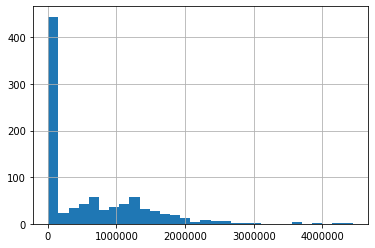

In [35]:
item_df['가격'].hist(bins=30);

In [9]:
# import pandas as pd
# df = pd.DataFrame({'링크':link_list, '상품명':item_name_list, '가격':price_list})
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   링크      910 non-null    object
 1   상품명     910 non-null    object
 2   가격      910 non-null    object
dtypes: object(3)
memory usage: 21.5+ KB


In [10]:
df['가격'] = df['가격'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   링크      910 non-null    object
 1   상품명     910 non-null    object
 2   가격      910 non-null    int32 
dtypes: int32(1), object(2)
memory usage: 17.9+ KB


In [11]:
df['가격'].mean()

637173.6593406594

In [12]:
# 엑셀저장위해 xlwt 설치
df.to_excel(f'쿠팡 {keyword} 검색결과.xls')

In [8]:
import random
import time
for _ in range(10):
    sec = round(random.uniform(0.3,1.2), 2)
    print(sec)
    time.sleep(sec)

0.58
1.06
1.1
0.57
0.74
1.12
1.15
1.06
1.05
0.51
